Dynamic programming in RL refers to techniques for exactly computing optimal policies given a perfect model of the environment, $p\left(r, s'\middle| s, a\right)$.

These are situations where we exactly know the environment dynamics.

## 4.1 Policy Evaluation (Prediction)

Policy evaluation is the mapping of policy to approximate value functions, $$ \pi \mapsto V\approx v_{\pi} $$ and $$ \pi \mapsto Q\approx q_{\pi} $$

#### State-value function

$$ v_\pi\left(s\right) := \mathbb{E}_{\pi}\left[ G_t \, \middle| \, S_t =s \right] = \sum_{a} \pi\left(a\middle|s\right) \sum_{r,s'} p\left(r,s'\middle|s,a\right)\left[r+\gamma v_{\pi}\left(s'\right)\right] $$

This is a linear system of $\left|\mathcal{S}\right|$ equations in $\left|\mathcal{S}\right|$ unknowns, and is theoretically solvable exactly.

Instead, we consider *approximating it by iterative updates*.

We just treat that expectation definition as an update rule:
$$ v_{k+1}\left(s\right) = \sum_a \pi\left(a\middle|s\right) \sum_{r,s'} p\left(s',r\middle|s,a\right)\left[r+\gamma v_{k}\left(s'\right)\right] $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import objects

In [2]:
dynamics = objects.get_dynamics4_1()
policy = objects.get_policy_epr(16, 4)

rewards_dict={0: -1.0, 1: 0.0}

V = objects.policy_evaluation(
    policy,
    dynamics,
    rewards_dict,
    1.0,
    theta=.001,
    max_iters=1_000,
)




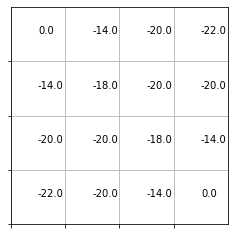

In [3]:
objects.plot_v2(V)

In [4]:
q = objects.calc_q_from_v(
    V,
    dynamics,
    rewards_dict=rewards_dict,
    gamma=1.0,
    )

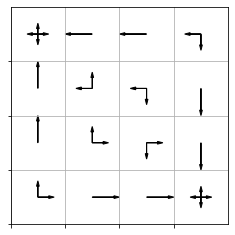

In [5]:
policy_greedy = objects.argmax_q(q)

objects.plot_policy2(policy_greedy)

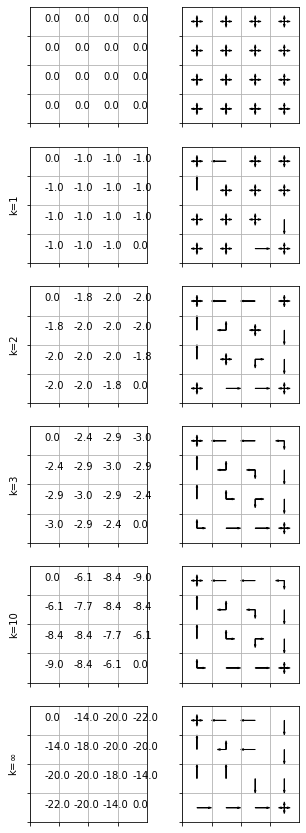

In [10]:
import objects
import matplotlib.pyplot as plt
import numpy as np

gamma = 1.0
dynamics = objects.get_dynamics4_1()
policy = objects.get_policy_epr(16, 4)
rewards_dict={0: -1.0, 1: 0.0}



fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(5,15))

v_init = np.zeros(16) # initial guess
policy_init = objects.calc_greedy_policy_from_v(v_init, dynamics, rewards_dict, gamma)
objects.plot_v2(v_init, ax[0,0])
objects.plot_policy2(policy_init, ax[0,1])


V_iter = v_init
for iter_idx in range(1, 4):

    # run for an iteration
    V_iter = objects.policy_evaluation(
        policy,
        dynamics,
        rewards_dict,
        1.0,
        max_iters=1,
        v_init=V_iter,
    )

    # get the greedy policy
    policy_iter = objects.calc_greedy_policy_from_v(V_iter, dynamics, rewards_dict, gamma)

    
    objects.plot_v2(V_iter,ax[iter_idx, 0])
    objects.plot_policy2(policy_iter, ax[iter_idx, 1])
    ax[iter_idx,0].set(ylabel=f"k={iter_idx}")


# get k = 10
V_iter = objects.policy_evaluation(
    policy,
    dynamics,
    rewards_dict,
    1.0,
    max_iters=7,
    v_init=V_iter,
)
policy_iter = objects.calc_greedy_policy_from_v(V_iter, dynamics, rewards_dict, gamma)    
objects.plot_v2(V_iter,ax[4, 0])
objects.plot_policy2(policy_iter, ax[4, 1])
ax[4,0].set(ylabel=f"k=10")


# get k = inf
V_iter = objects.policy_evaluation(
    policy,
    dynamics,
    rewards_dict,
    1.0,
    max_iters=200,
    v_init=V_iter,
)
policy_iter = objects.calc_greedy_policy_from_v(V_iter, dynamics, rewards_dict, gamma)    
objects.plot_v2(V_iter,ax[5, 0])
objects.plot_policy2(policy_iter, ax[5, 1])
ax[5,0].set(ylabel=r"k=$\infty$")
plt.show()


## 4.2 Policy Improvement

The policy improvement algorithm takes a policy $\pi$, evaluates it to obtain $V\approx v_{\pi}$, and uses these value estimates to determine how to "act better", i.e., it uses the value estimates to construct a new policy.

This is straightforward: we can improve a policy $\pi$ by creating a new policy $\pi'$ which is defined by acting greedily with respect to the original policy's value function $v_{\pi}$.

In [6]:
import objects
import matplotlib.pyplot as plt

# Start with equiprobably random policy
policy = objects.get_policy_epr(16, 4)
dynamics = objects.get_dynamics4_1()
rewards_dict = {0: -1.0, 1: 0.0}

# Compute the state-value function
v = objects.policy_evaluation(
    policy,
    dynamics,
    rewards_dict,
    gamma=1.0,
    max_iters=200,
)

In [7]:
gamma = 1.0
# act greedily and get the new policy
policy_new = objects.policy_improvement(
    dynamics=dynamics,
    rewards_dict=rewards_dict,
    v=v,
    gamma=gamma,
)
# calc the new value function
v_new = objects.policy_evaluation(
    policy_new,
    dynamics,
    rewards_dict,
    gamma,
    )

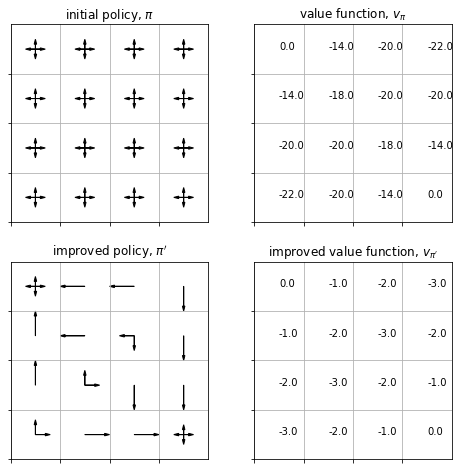

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
objects.plot_policy2(policy, ax[0,0])
objects.plot_v2(v, ax[0,1])
objects.plot_policy2(policy_new, ax[1,0])
objects.plot_v2(v_new, ax[1,1])

ax[0,0].set_title(r"initial policy, $\pi$")
ax[0,1].set_title(r"value function, $v_{\pi}$")
ax[1,0].set_title(r"improved policy, $\pi'$")
ax[1,1].set_title(r"improved value function, $v_{\pi'}$")
plt.show()

## 4.3 Policy Iteration

In 4.2 the authors show that doing policy improvement by acting greedily will always get us a better policy. But there's no guarantee that it's optimal! In general, we can repeat this loop of policy evaluation followed by policy improvement, and call this iterative procedure "policy iteration."

In [14]:
import objects
import matplotlib.pyplot as plt

# Start with equiprobably random policy
policy = objects.get_policy_epr(16, 4)
dynamics = objects.get_dynamics4_1()
rewards_dict = {0: -1.0, 1: 0.0}
gamma = 1.0

for iter in range(10):
    # Evaluate current policy
    v = objects.policy_evaluation(
        policy,
        dynamics,
        rewards_dict,
        gamma=gamma,
        max_iters=200,
    )

    # Improve current policy
    policy_new = objects.policy_improvement(
        dynamics=dynamics,
        rewards_dict=rewards_dict,
        v=v,
        gamma=gamma,
    )

    # Update current policy
    policy = policy_new

policy_opt = policy

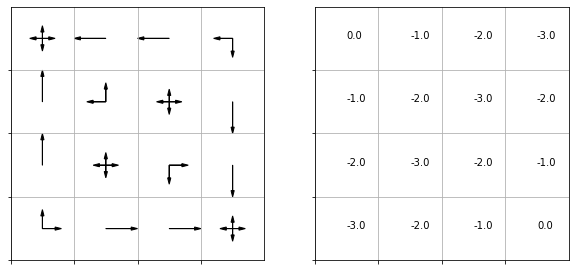

In [17]:
v_opt = objects.policy_evaluation(
    policy_opt,
    dynamics,
    rewards_dict,
    gamma,
)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
objects.plot_policy2(policy_opt, ax[0])
objects.plot_v2(v_opt, ax[1])

Does this make sense? The optimal policy clearly reflects exactly the symmetry of the problem dynamics. Since we are not discounting here, and each step gets a reward (penalty) of -1.0, the value function for a state $s$ is exactly the number of steps that it will take for us to get from that state $s$ to the terminal state. Conclusion: this makes sense!

Let's try it for the earlier Gridworld example, Example 3.5.

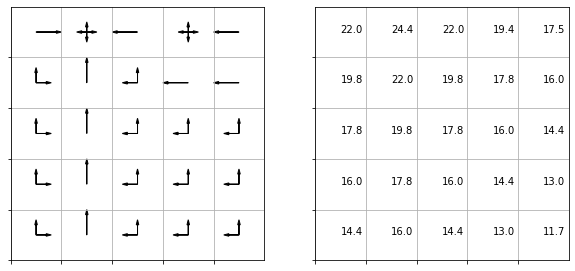

In [19]:
import objects
import matplotlib.pyplot as plt

# Start with equiprobably random policy
policy = objects.get_policy_epr(25, 5)
dynamics = objects.get_dynamics()
rewards_dict = {0: -1.0, 1: 0.0, 2: 5.0, 3: 10.0}
gamma = 0.9

for iter in range(10):
    # Evaluate current policy
    v = objects.policy_evaluation(
        policy,
        dynamics,
        rewards_dict,
        gamma=gamma,
        max_iters=200,
    )

    # Improve current policy
    policy_new = objects.policy_improvement(
        dynamics=dynamics,
        rewards_dict=rewards_dict,
        v=v,
        gamma=gamma,
    )

    # Update current policy
    policy = policy_new

policy_opt = policy

v_opt = objects.policy_evaluation(
    policy_opt,
    dynamics,
    rewards_dict,
    gamma,
)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
objects.plot_policy2(policy_opt, ax[0])
objects.plot_v2(v_opt, ax[1])

### Jack's car rental problem



In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# State space: number of cars at each location
# S = [0, 20]^2
state = (4, 5) # state is now a vector!

# Action space: number of cars moved from location 1 to location 2
actions = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5] 

In [74]:
states = [(x,y) for x in range(21) for y in range(21)]
n_actions = len(actions)
p = 1/len(actions)
policy = {
    state: p*np.ones(n_actions) for state in states
}

How to encode the dynamics for this problem?

Think about one location.

The state for this location will change based on Jack's actions during the night: if he chooses to move $A = a$ cars to or from this location, he incurs a cost of \$2 per car and the state will change before the customers walk in. This change to the state is deterministic.

$$ s' = s + a, \, a \in \mathcal{A}$$
and 
$$ r' = -2 \cdot a $$
where $s'$ is the supply at the start of the day.

During the next day, some customers will rent cars and some will return cars. We are told to model both of these as Poisson random variables, so let $n$ be the number of cars rented from the location and $m$ be the number returned to the location. Then
$$ n \sim \text{Poisson}\left(\lambda_{\text{rent}}\right) $$
 and 
 $$ m \sim \text{Poisson}\left(\lambda_{\text{return}}\right). $$

The number of customers that rent from the location, $n$, will affect the supply $s'$. If the supply is greater than the demand, or $s' > n$, then there will be $s'' = s' - n >= 0 $ cars left at the end of the day. Otherwise, there will be $s'' = 0$ cars left.

$$ s'' = \left\{ \begin{array}{rl} s' - n, & s' - n > 0 \\ 0, & s' - n <= 0 \end{array}\right.  = \max \left\{ s' - n, 0 \right\} =\max \left\{ s+a - n, 0 \right\} $$

The number of customers that return cars, $m$, will then dictate how many cars are available the next day:
$$ s''' = \max\left\{s + a - n, 0 \right\} + m $$

How is the reward for renting cars constructed? Jack gets \$10 for every car he can supply, but he can supply at most $s'$ cars. So if $n > s'$, he will get $10s'$, but if $n < s'$, he will get $10n$.

$$ r'' = \left\{ \begin{array}{rl} 
 10 * n , & s' - n > 0  \\
 10 * s', & s' - n \leq 0 \\
\end{array} \right. $$

or 
$$ r'' = 10 \cdot \min\left\{n, s' \right\} $$

Putting this all together, the total reward for taking action $a$ in state $s$ will be $$ r = 10 \cdot \min \left\{ n, \, s + a \right\} - 2 \cdot a $$ 
and the state transition looks like $
$$ s' = \max\left\{s + a - n, 0 \right\} + m $$


Note that these dynamics are *stochastic* because the variable $n$ is randomly generated! Before a particular day (time step), we don't know ahead of time exactly what $n$ will be.

To account for both locations at once, we will have
$$ n_1 \sim \text{Poisson}\left(\lambda^{\text{rent}}_1\right) $$
$$ n_2 \sim \text{Poisson}\left(\lambda^{\text{rent}}_2\right) $$
$$ m_1 \sim \text{Poisson}\left(\lambda^{\text{return}}_1\right) $$
$$ m_2 \sim \text{Poisson}\left(\lambda^{\text{return}}_2\right) $$

$$ r = 10 \cdot \min\left\{ n_1, \, s_1 - a \right\} + 10 \cdot \min \left\{ n_2, \, s_2 + a\right\} -2 \cdot a $$
$$ \left[ \begin{array}{c} s_1' \\ s_2' \end{array}\right] = \left[ \begin{array}{cc} \max \left\{ s_1 - a - n_1, \, 0 \right\} + m_1 \\ \max \left\{ s_2 + a - n_2, \, 0 \right\} + m_2 \end{array}\right] $$


The uncertainty in this problems comes from the fact that $n_1$ and $n_2$ are stochastic. We can compute the dynamics for this problem as a mapping $$ \text{dynamics}:$$ 

\begin{align}
    p\left(r, s'\middle| s, a\right) & = \sum_{n_1} p\left(r, s'\middle| n_1, s, a\right) p\left(n_1 \middle| s, a\right) \\
    & = \sum_{n_1} p\left(r, s'\middle| n_1, s, a\right) p\left(n_1\right)
\end{align}
where we used the fact that $n_1$ is drawn independently of the current state or action. Continuing, 
\begin{align}
    p\left(r, s'\middle| s, a\right) & = \sum_{n_1, n_2, m_1, m_2} p\left(r, s'\middle| n_1, n_2, m_1, m_2, s, a\right) p\left(n_1\right)p\left(n_2\right)p\left(m_1\right)p\left(m_2\right) \\
\end{align}

The first factor in the product being summed is interesting. Above We have written $r$ and $s'$ as deterministic functions of the conditioning variables, and so this distribution is degenerate; that is, it assigns nonzero probability mass to only one combination of $\left(r, s'\right)$.

So, to construct the dynamics, we don't need to loop over all possible rewards, but we can loop instead over all possible $\left(n_1, n_2\right)$ and generate the resultant steps and rewards.

$$ r = 10 \cdot \min\left\{ n_1, \, s_1 - a \right\} + 10 \cdot \min \left\{ n_2, \, s_2 + a\right\} -2 \cdot a $$
$$ \left[ \begin{array}{c} s_1' \\ s_2' \end{array}\right] = \left[ \begin{array}{cc} \max \left\{ s_1 - a - n_1, \, 0 \right\} + m_1 \\ \max \left\{ s_2 + a - n_2, \, 0 \right\} + m_2 \end{array}\right] $$

In [ ]:
np.random.poisson.pdf

In [93]:
import scipy.stats as ss
lam_1_rent = 3
lam_2_rent = 4
lam_1_ret = 3
lam_2_ret = 2

n = [(n_1, n_2) for n_1 in range(20) for n_2 in range(20)]
m = [(m_1, m_2) for m_1 in range(20) for m_2 in range(20)]

states = [(s_1, s_2) for s_1 in range(20) for s_2 in range(20)]
actions = range(-20,21,1)

dynamics_dict = dict()
for n_1, n_2 in n:
    for m_1, m_2 in m:
        for s_1, s_2 in states:
            for a in actions:
                r = 10 * np.min([n_1, s_1 -a]) + 10 * np.min([n_2, s_2 + a]) - 2*a
                sp = (np.max([s_1 - a - n_1, 0]) + m_1, np.max([s_2 + a - n_2, 0]) + m_2)
                p_nm = ss.poisson.pmf(mu=lam_1_rent, k=n_1)
                p_nm *= ss.poisson.pmf(mu=lam_2_rent, k=n_2)
                p_nm *= ss.poisson.pmf(mu=lam_1_ret, k=m_1)
                p_nm *= ss.poisson.pmf(mu=lam_2_ret, k=m_2)
                
                key_sa = f"(({s_1},{s_2}),a)"
                key_spr = f"(({sp[0]},{sp[1]}),{r})"

                if key_sa in dynamics_dict:
                    if key_spr in dynamics_dict[key_sa]:
                        dynamics_dict[key_sa][key_spr] += p_nm
                    else:
                        dynamics_dict[key_sa][key_spr] = p_nm
                else:
                    dynamics_dict[key_sa] = {key_spr: p_nm}
                    

KeyboardInterrupt: 

In [109]:
import scipy.stats as ss
lam_1_rent = 3
lam_2_rent = 4
lam_1_ret = 3
lam_2_ret = 2

# precompute the probabilities for the customer occurrences
p_custs = np.zeros((20,20,20,20)) # (n_1, n_2, n_3, n_4)

for n_1 in range(20):
    for n_2 in range(20):
        for m_1 in range(20):
            for m_2 in range(20):
                tmp = np.log(ss.poisson.pmf(mu=lam_1_rent, k=n_1))
                tmp += np.log(ss.poisson.pmf(mu=lam_2_rent, k=n_2))
                tmp += np.log(ss.poisson.pmf(mu=lam_1_ret, k=m_1))
                tmp += np.log(ss.poisson.pmf(mu=lam_2_ret, k=m_2))
                p_custs[n_1,n_2,m_1,m_2] = np.exp(tmp)


(16, (20, 1))

In [120]:
states_tup = [ (i,j) for i in range(20) for j in range(20) ]
states = range(len(states_tup))
actions = range(-20, 21, 1)

def calc_s(st, a, n_1, n_2, m_1, m_2):
    return (
        np.min(
            [np.max([st[0] - a - n_1, 0]) + m_1, 20]
        ), 
        np.min(
            [np.max([st[1] + a - n_2, 0]) + m_2, 20]
        )
    )

def calc_r(st, a, n_1, n_2):
    return int(10 * np.min([n_1, st[0] - a]) + 10 * np.min([n_2, st[1] + a]) - 2 * a)




s = 5
st = states_tup[s]
a = 8

dyn_list = []

for n_1 in range(20):
    for n_2 in range(20):
        # calc r
        r = calc_r(st, a, n_1, n_2)
        
        for m_1 in range(20):
            for m_2 in range(20):
                # calc s'
                sp = calc_s(st, a, n_1, n_2, m_1, m_2)

                # look up p
                p = p_custs[n_1, n_2, m_1, m_2] 

                dyn_list.append((sp, r, p))



In [121]:
dyn_list

[((0, 13), -96, 6.14421235332821e-06),
 ((0, 14), -96, 1.2288424706656421e-05),
 ((0, 15), -96, 1.2288424706656421e-05),
 ((0, 16), -96, 8.192283137770939e-06),
 ((0, 17), -96, 4.096141568885476e-06),
 ((0, 18), -96, 1.6384566275541888e-06),
 ((0, 19), -96, 5.461522091847289e-07),
 ((0, 20), -96, 1.5604348833849397e-07),
 ((0, 20), -96, 3.9010872084623485e-08),
 ((0, 20), -96, 8.669082685471912e-09),
 ((0, 20), -96, 1.7338165370943776e-09),
 ((0, 20), -96, 3.1523937038079593e-10),
 ((0, 20), -96, 5.253989506346601e-11),
 ((0, 20), -96, 8.08306077899479e-12),
 ((0, 20), -96, 1.154722968427825e-12),
 ((0, 20), -96, 1.5396306245704299e-13),
 ((0, 20), -96, 1.9245382807130335e-14),
 ((0, 20), -96, 2.264162683191818e-15),
 ((0, 20), -96, 2.5157363146575696e-16),
 ((0, 20), -96, 2.6481434891132318e-17),
 ((1, 13), -96, 1.8432637059984652e-05),
 ((1, 14), -96, 3.6865274119969305e-05),
 ((1, 15), -96, 3.6865274119969305e-05),
 ((1, 16), -96, 2.4576849413312843e-05),
 ((1, 17), -96, 1.228842470

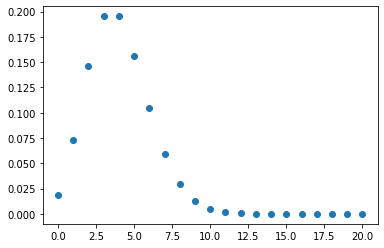

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

lambda_1_rent = 4
x = np.arange(0, 21, 1)
p = [ss.poisson.pmf(xi, mu=lambda_1_rent) for xi in x]

plt.scatter(x, p)

In [2]:
states = [(i,j) for i in range(20) for j in range(20)]
actions = range(-5,6)
lam_rent = [3, 4]
lam_ret = [3, 2]

def calc_p(n_1, n_2, m_1, m_2, lam_rent, lam_ret):
    log_p = np.log(ss.poisson.pmf(k=n_1, mu=lam_rent[0]))
    log_p += np.log(ss.poisson.pmf(k=n_2, mu=lam_rent[1]))
    log_p += np.log(ss.poisson.pmf(k=m_1, mu=lam_ret[0]))
    log_p += np.log(ss.poisson.pmf(k=m_2, mu=lam_ret[1]))
    return np.exp(log_p)


def calc_sp(st, a, n_1, n_2, m_1, m_2):
    state_tuple = (
        np.min(
            [np.max([st[0] - a - n_1, 0]) + m_1, 20]
        ), 
        np.min(
            [np.max([st[1] + a - n_2, 0]) + m_2, 20]
        )
    )
    
    return state_tuple

def calc_r(st, a, n_1, n_2):
    return int(10 * np.min([n_1, st[0] - a]) + 10 * np.min([n_2, st[1] + a]) - 2 * a)

def dynamics(s_idx: int, a_idx: int):
    """
        Returns:
            list: List of tuples of the form (s', r, p)
    """
    dynamics_list = []
    for n_1 in range(10):
        for n_2 in range(10):
            for m_1 in range(10):
                for m_2 in range(10):
                    # calculate return
                    r = calc_r(states[s_idx], actions[a_idx], n_1, n_2)
                    # calculate s'
                    sp = calc_sp(states[s_idx], actions[a_idx], n_1, n_2, m_1, m_2)
                    # calculate p
                    p = calc_p(n_1, n_2, m_1, m_2, lam_rent, lam_ret)
                    dynamics_list.append((sp, r, p))

    return dynamics_list

In [3]:
dl = dynamics(44, 4)

$$ v_{k+1}\left(s\right) = \sum_{a} \pi\left(a\middle|s\right) \sum_{r,s'} p\left(r,s'\middle|s,a\right)\left[r+\gamma v_{k}\left(s'\right)\right] $$

In [6]:
def calc_update_for_v(state_idx: int, v: np.ndarray):
    """Calculate the update for v(s) as the expected value of future rewards."""
    n_actions = len(actions)
    
    expected_reward = 0.0
    for action_idx in range(n_actions):
        dynamics_list = dynamics(s_idx=state_idx, a_idx=action_idx)
        for sp, r, p in dynamics_list:
            expected_reward += policy[sp, action_idx] * p * (r + gamma * v[sp])

    return expected_reward